# Project 5

## Data Description:


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

## Goal(s):


Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


## Success Metrics:


Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

Plan: 
1 - Data preparation
2 - Exploratory Data Analysis 
3 - Feature engineering
4 - Model selection
5 - Decision making
<!-- Data Preparation:

Combine all the different sheets into a single dataset.
Check for any missing or null values and handle them appropriately.
Convert the date column to a datetime format for easy manipulation.
Extract the day, week, and month from the date column for daily, weekly, and monthly predictions.

Exploratory Data Analysis (EDA):

Conduct a comprehensive EDA to identify patterns, trends, and outliers in the data.
Use visualizations such as line plots, scatter plots, histograms, and box plots to explore the data.
Calculate basic statistics such as mean, median, standard deviation, and correlation to gain insights into the data.

Feature Engineering:

Create new features such as moving averages, exponential moving averages, and Bollinger Bands to help capture trends and patterns in the data.
Use technical indicators such as Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and Stochastic Oscillator to create additional features.

Model Selection:

Select appropriate models such as Linear Regression, Random Forest Regression, and Support Vector Regression (SVR) to predict the stock prices.
Train the models using the 2020 data and test them on the 2021 Q1 data.
Use evaluation metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared to evaluate the performance of the models.

Decision Making:

Use the predicted stock prices to make BUY, HOLD, or SELL decisions.
Calculate the capital returns based on the decisions made.
Use Bollinger Bands to measure the effectiveness of the system.
Minimize the HOLD period by adjusting the decision-making criteria based on the performance of the system -->

In [1]:
#!pip install statsmodels --upgrade
#!pip install TA-Lib
#!pip install fbprophet

In [4]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

import re
from pylab import rcParams
import statsmodels.api as sm

import talib as ta

import itertools

# Algorithms

from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM


# #Cross validation
# from sklearn.model_selection import KFold, cross_val_score

# #Other
# from sklearn import metrics
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

# #class imbalance
# from sklearn.metrics import f1_score
# from sklearn.utils import resample


Importing plotly failed. Interactive plots will not work.


# 1 - Data preparation

In [5]:
def clean_sheets(og_data, num):
    def remove_letters(val):
        if isinstance(val, str):
            num = re.findall(r"\d+\.?\d*", val)
            if len(num) > 0:
                num = float(num[0])
                if "K" in val:
                    num /= 1000
                elif "M" in val:
                    num *= 1
                return num
        return val
    data = og_data.parse(num)
    # remove the last row as it contains text
    data.drop([data.shape[0]-1], axis=0, inplace=True)
    #clean up date column
    data[["Date"]] = data[["Date"]].apply(pd.to_datetime)
    #clean up Vol column
    data['Vol.'] = data['Vol.'].apply(remove_letters)
    #make columns numeric
    data[["Price", "Open", "High", "Low", 'Vol.', "Change %"]] = data[["Price", "Open", "High", "Low", 'Vol.', "Change %"]].apply(pd.to_numeric)
    # make the Date values the index
    data = data.sort_values(by=['Date'], ascending=True)
    print(data.head())
        # Check data types of columns
    print(data.dtypes)

    # Check for missing values
    print(data.isnull().sum())
    return data

In [6]:
og_data = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [7]:
data1 = clean_sheets(og_data, 1)

          Date  Price   Open   High    Low  Vol.  Change %
314 2020-01-02  20.38  20.42  20.44  20.24  2.53    0.0030
313 2020-01-03  20.30  20.30  20.44  19.97  3.31   -0.0039
312 2020-01-06  20.08  20.34  20.34  19.97  1.94   -0.0108
311 2020-01-07  19.93  20.22  20.28  19.92  2.89   -0.0075
310 2020-01-08  19.94  19.89  19.95  19.66  2.79    0.0005
Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.               float64
Change %           float64
dtype: object
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [8]:
data1.head()

,Date,Price,Open,High,Low,Vol.,Change %
314,2020-01-02,20.38,20.42,20.44,20.24,2.53,0.0030
313,2020-01-03,20.30,20.30,20.44,19.97,3.31,-0.0039
312,2020-01-06,20.08,20.34,20.34,19.97,1.94,-0.0108
311,2020-01-07,19.93,20.22,20.28,19.92,2.89,-0.0075
310,2020-01-08,19.94,19.89,19.95,19.66,2.79,0.0005


In [9]:
data1.tail()

,Date,Price,Open,High,Low,Vol.,Change %
4,2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148
3,2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385
2,2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078
1,2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209
0,2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046


# 2 - Exploratory Data Analysis 

In [10]:
def exploration(df):
    
    # Summary statistics of the data
    print(df.describe())
        # Visualize data distribution of numeric columns
    df.hist(bins=10, figsize=(15, 10))
    plt.show()

    # Visualize correlation between variables
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.show()

    # Explore relationships between variables using scatter plots
    sns.pairplot(df, x_vars=['Price', 'Vol.'], y_vars=['Change %'], size=5, aspect=0.8, kind='scatter')
    plt.show()

            Price        Open        High         Low        Vol.    Change %
count  315.000000  315.000000  315.000000  315.000000  315.000000  315.000000
mean    17.857397   17.879397   18.146286   17.608667   11.087810    0.000149
std      2.891400    2.877779    2.944378    2.850359    8.029082    0.024198
min     12.790000   12.970000   13.110000   12.380000    1.920000   -0.099400
25%     15.010000   15.080000   15.225000   14.840000    5.685000   -0.013350
50%     17.580000   17.640000   17.860000   17.450000    8.720000    0.000700
75%     20.130000   20.190000   20.360000   19.970000   13.830000    0.014950
max     24.080000   24.380000   25.480000   23.480000   56.570000    0.078000


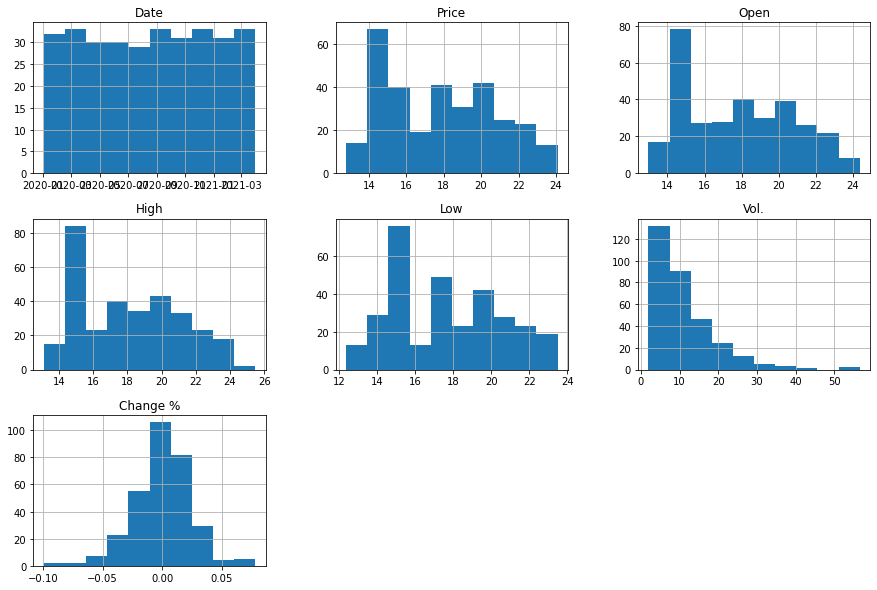

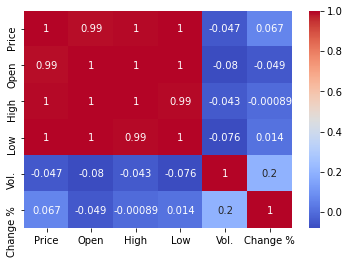

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


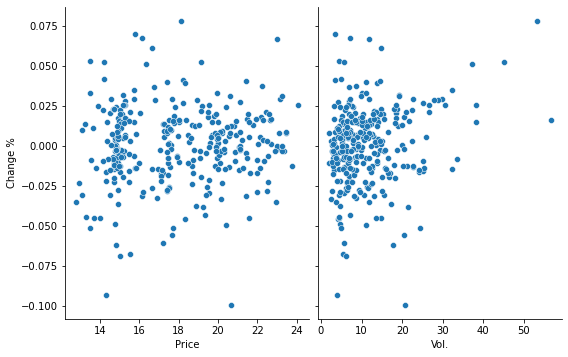

In [11]:
exploration(data1)

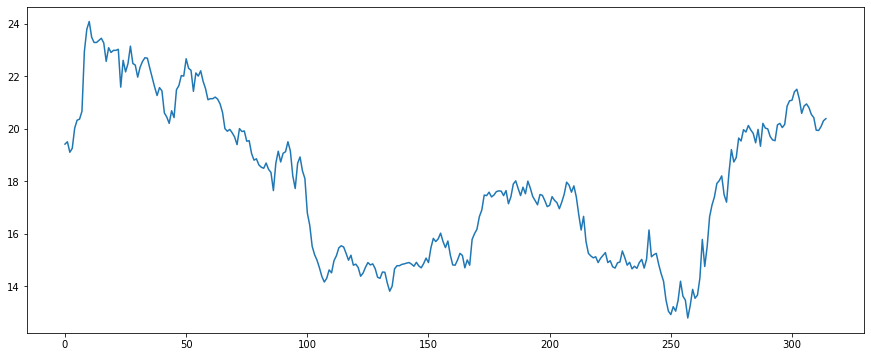

In [12]:
y = data1['Price']
y.plot(figsize=(15, 6))
plt.show()

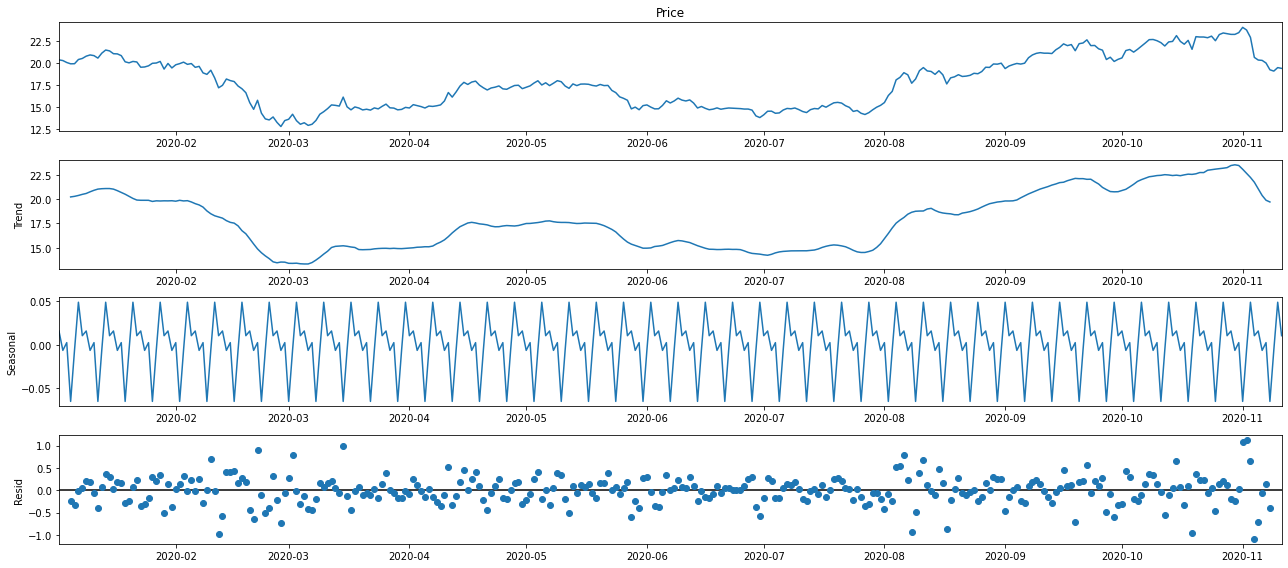

In [13]:
y.index = pd.date_range(start='2020-01-02', periods=len(y), freq='D')

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# 3 - Feature engineering

In [22]:
def engineering(df):
    
    # Create a new column for the rolling mean
    df['MA_20'] = df['Price'].rolling(window=20).mean()

    # Create a new column for the exponential moving average
    df['EMA_20'] = df['Price'].ewm(span=20, adjust=False).mean()

    # Create new columns for Bollinger Bands
    df['MA_20'] = df['Price'].rolling(window=20).mean()
    df['std_20'] = df['Price'].rolling(window=20).std()
    df['Upper_BB'] = df['MA_20'] + 2*df['std_20']
    df['Lower_BB'] = df['MA_20'] - 2*df['std_20']
    
    # Create new columns for RSI, MACD, and Stochastic Oscillator
    df['RSI_14'] = ta.RSI(df['Price'], 14)
    df['MACD'], macdsignal, macdhist = ta.MACD(df['Price'],  fastperiod=6, slowperiod=9, signalperiod=3)
    df['Stoch_OscillatorK'], df['Stoch_OscillatorD'] = ta.STOCH(df['High'], df['Low'], df['Price'], fastk_period=5, slowk_period=3, slowd_period=3)

    return df

data1b = engineering(data1)

Q: need to run twice otherwise get a lot of NaN

In [24]:
data1b.head(30)

,Date,Price,Open,High,Low,Vol.,Change %,MA_20,EMA_20,std_20,Upper_BB,Lower_BB,RSI_14,MACD,Stoch_OscillatorK,Stoch_OscillatorD
314,2020-01-02,20.38,20.42,20.44,20.24,2.53,0.0030,NaN,20.380000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,2020-01-03,20.30,20.30,20.44,19.97,3.31,-0.0039,NaN,20.372381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,2020-01-06,20.08,20.34,20.34,19.97,1.94,-0.0108,NaN,20.344535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,2020-01-07,19.93,20.22,20.28,19.92,2.89,-0.0075,NaN,20.305056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,2020-01-08,19.94,19.89,19.95,19.66,2.79,0.0005,NaN,20.270288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,2020-01-09,20.42,20.20,20.58,20.08,7.94,0.0241,NaN,20.284547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,2020-01-10,20.54,20.54,20.70,20.26,4.38,0.0059,NaN,20.308876,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,2020-01-13,20.80,20.52,20.86,20.50,4.50,0.0127,NaN,20.355649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,2020-01-14,20.94,20.80,20.96,20.62,4.06,0.0067,NaN,20.411302,NaN,NaN,NaN,NaN,NaN,92.692308,82.602502
305,2020-01-15,20.86,20.86,21.28,20.54,4.93,-0.0038,NaN,20.454035,NaN,NaN,NaN,NaN,NaN,86.153846,88.751394


In [25]:
# # Load the data into a pandas DataFrame
# df = pd.read_csv('stock_prices.csv')

# # Convert the Date column to a datetime object
# df['Date'] = pd.to_datetime(df['Date'])

# # Set the Date column as the index
# df.set_index('Date', inplace=True)

# # Calculate the exponential moving average with a smoothing factor of 0.5
# df['EMA_0.5'] = df['Price'].ewm(alpha=0.5, adjust=False).mean()

# # Calculate the simple moving average with a window of 10 days
# df['SMA_10'] = df['Price'].rolling(window=10).mean()

# 4 - Models

In [26]:
data1b.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'MA_20',
       'EMA_20', 'std_20', 'Upper_BB', 'Lower_BB', 'RSI_14', 'MACD',
       'Stoch_OscillatorK', 'Stoch_OscillatorD'],
      dtype='object')

In [27]:
df = data1b.iloc[20:]
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,MA_20,EMA_20,std_20,Upper_BB,Lower_BB,RSI_14,MACD,Stoch_OscillatorK,Stoch_OscillatorD
294,2020-01-30,20.14,20.18,20.18,19.79,2.64,-0.0030,20.5985,20.563210,0.493881,21.586262,19.610738,45.276883,-0.103692,18.285905,12.865418
293,2020-01-31,19.54,20.12,20.12,19.54,5.75,-0.0298,20.5605,20.465762,0.544682,21.649864,19.471136,37.384560,-0.153811,15.449025,14.730286
292,2020-02-03,19.57,19.56,19.65,19.42,3.09,0.0015,20.5350,20.380451,0.579205,21.693411,19.376589,37.966807,-0.171089,13.643931,15.792954
291,2020-02-04,19.70,19.68,19.73,19.38,8.67,0.0066,20.5235,20.315646,0.593946,21.711391,19.335609,40.546739,-0.160043,17.665805,15.586254
290,2020-02-05,19.99,19.75,20.14,19.62,8.12,0.0147,20.5260,20.284632,0.591460,21.708921,19.343079,45.947321,-0.119729,43.082472,24.797403


In [28]:
columns = ['Change %', 'MA_20',
       'EMA_20', 'std_20', 'Upper_BB', 'Lower_BB', 'RSI_14', 'MACD',
       'Stoch_OscillatorK', 'Stoch_OscillatorD']
# Split the data into training and testing sets
train_X = df.loc[df.Date < '2021-01-01', columns]
train_Y = df.loc[df.Date < '2021-01-01', 'Price']
test_X = df.loc[df.Date >= '2021-01-01', columns]
test_Y = df.loc[df.Date >= '2021-01-01', 'Price']

## Linear Regression, Random Forest and SVR models

In [29]:
# Create and train the models
lr_model = LinearRegression().fit(train_X, train_Y)
rf_model = RandomForestRegressor().fit(train_X, train_Y)
svr_model = SVR().fit(train_X, train_Y)

# Predict the prices using the trained models
lr_predictions = lr_model.predict(test_X)
rf_predictions = rf_model.predict(test_X)
svr_predictions = svr_model.predict(test_X)

# Evaluate the performance of the models
lr_mse = mean_squared_error(test_Y, lr_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(test_Y, lr_predictions)

rf_mse = mean_squared_error(test_Y, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(test_Y, rf_predictions)

svr_mse = mean_squared_error(test_Y, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_r2 = r2_score(test_Y, svr_predictions)

print(f"Linear Regression: MSE={lr_mse}, RMSE={lr_rmse}, R^2={lr_r2}")
print(f"Random Forest Regression: MSE={rf_mse}, RMSE={rf_rmse}, R^2={rf_r2}")
print(f"SVR: MSE={svr_mse}, RMSE={svr_rmse}, R^2={svr_r2}")


Linear Regression: MSE=0.016489176105027287, RMSE=0.12841018692077077, R^2=0.987853220233164
Random Forest Regression: MSE=5.158440997142842, RMSE=2.2712201560268968, R^2=-2.7999743791570184
SVR: MSE=11.294560657046462, RMSE=3.3607381119400634, R^2=-7.320157416627122


## LTSM model

In [30]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size][columns]
test = df.iloc[train_size:][columns]
ytr = df.iloc[:train_size]['Price']
yte = df.iloc[train_size:]['Price']

# # Scale the data
# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train)
# test_scaled = scaler.transform(test)

# Create the dataset
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i: i + time_steps])
        ys.append(y.iloc[i: i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps=10
X_train, y_train = create_dataset(train, ytr, time_steps)
X_test, y_test = create_dataset(test, yte, time_steps)

# Build the model

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, verbose=0)

# Evaluate the model on test data
model.evaluate(X_test, y_test)

# Make predictions
y_pred = model.predict(X_test)

ltsm_mse = mean_squared_error(y_test, y_pred)
ltsm_rmse = np.sqrt(ltsm_mse)
ltsm_r2 = r2_score(y_test, y_pred)

print(f"LTSM: MSE={ltsm_mse}, RMSE={ltsm_rmse}, R^2={ltsm_r2}")

2/2 [==============================] - 0s 4ms/step


ValueError: y_true and y_pred have different number of output (10!=1)

## Prophet model

In [53]:
# Rename the columns to the required format for Prophet
df.columns = ['ds', 'y', 'open', 'high', 'low', 'vol','change', 'ma20', 'ema20', 'std20', 'upper_bb', 'lower_bb', 'rsi', 'macd', 'stoch_k', 'stoch_d']
df.loc[:, ['ds', 'y', 'open', 'high', 'ma20', 'ema20', 'std20', 'upper_bb', 'lower_bb', 'rsi', 'macd', 'stoch_k', 'stoch_d']]
# Create a Prophet model
model = Prophet()

# Add regressor variables to the model
model.add_regressor('ema20')
model.add_regressor('std20')
model.add_regressor('upper_bb')
model.add_regressor('lower_bb')
model.add_regressor('rsi')
model.add_regressor('macd')
model.add_regressor('stoch_k')
model.add_regressor('stoch_d')

# Fit the model to the data
model.fit(df)

# Create a dataframe for the future dates we want to predict
future_dates = model.make_future_dataframe(periods=365)

# Add the regressor variables to the future dataframe
future_dates['ema20'] = df['ema20']
future_dates['std20'] = df['std20']
future_dates['upper_bb'] = df['upper_bb']
future_dates['lower_bb'] = df['lower_bb']
future_dates['rsi'] = df['rsi']
future_dates['macd'] = df['macd']
future_dates['stoch_k'] = df['stoch_k']
future_dates['stoch_d'] = df['stoch_d']

# Make predictions for the future dates
predictions = model.predict(future_dates)

# Plot the predictions
model.plot(predictions)


18:46:44 - cmdstanpy - INFO - Chain [1] start processing
18:46:44 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found NaN in column 'ema20'

## ARIMA model

In [54]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [55]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(y,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2711.082911202231
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2246.8099692653277
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1167.1874229720738
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1129.6883125998952


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1172.2571371733816
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1170.3015714647095
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1133.3411900342762
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1131.3618820097568
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2284.7030798327487
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1846.5000012268056
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:887.9865730381505
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:859.6979393898051
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:895.0380707074564
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:891.063944850071
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:863.4720243257652
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:859.3748813611346
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:362.73937872876814
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:355.64680081750583
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:520.0176343622502
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:367.44819161433077
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:355.7414200741714
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:357.52652465474887
A

ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:355.64680081750583 is the lowest AIC

In [56]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.0863      0.058      1.488      0.137      -0.027       0.200
sigma2         0.1883      0.010     18.670      0.000       0.168       0.208


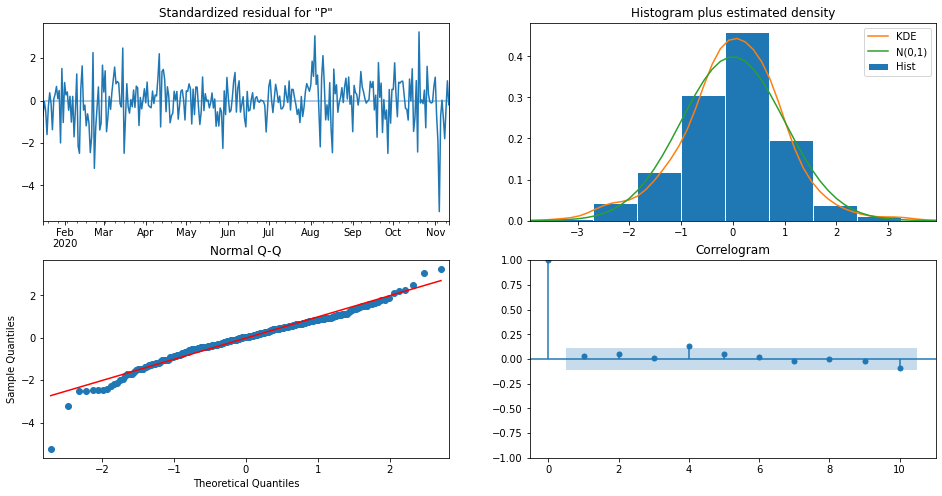

In [57]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

<class 'pandas.core.frame.DataFrame'>


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)

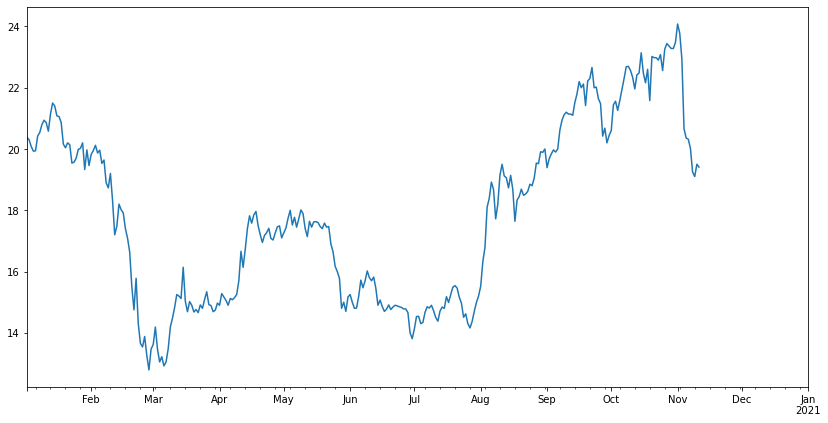

In [58]:
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()
print(type(pred_ci))
ax = y['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Q: make the time series stationary?
scaler?